<a href="https://colab.research.google.com/github/philadelphia24/Thesis-Job-Recommender-System-/blob/main/Collaborative%20Filtering%20(user-based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering

The code is largely derived from: https://surprise.readthedocs.io/en/stable/FAQ.html from section: "How to save some data for unbiased accuracy estimation"

In [ ]:
# STEP 1: import libraries and data

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
!pip install auto-surprise
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNWithZScore, BaselineOnly, CoClustering # We will not be using all of these, but you can select the ones of interest.
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095450 sha256=5d0f379e1bfaa61a8ab5db26610a641bc949c544bc8c124f11386582e9444cff
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Let's import our data
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['matches.csv'])) #change according to noise level

# Making the experiments reproducible
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

Saving matches.csv to matches (14).csv


In [ ]:
# Step 2: Instantiate reader and data, then split the data.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['JobseekerID', 'VacancyID', 'Rating']], reader)
raw_ratings = data.raw_ratings

# Shuffling the ratings ensures that the data is randomly ordered before being split into training and testing set
random.shuffle(raw_ratings)

# train= 80% of the data, test = 20% of the data
threshold = int(0.8 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

# Let's check the split
print("Number of rows in train_raw_ratings:", len(train_raw_ratings))
print("Number of rows in test_raw_ratings:", len(test_raw_ratings))

data.raw_ratings = train_raw_ratings  # data is now the set train_raw_ratings

Number of rows in train_raw_ratings: 36253
Number of rows in test_raw_ratings: 9064


## Clean data

### SVD

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [15, 20, 25], # number of latent factors to be learned by the algorithm
    "n_epochs": [80, 85, 90], # number of iterations of the stochastic gradient descent optimization algorithm
    "lr_all": [0.004], # learning rate for all parameters in the model.
    "reg_all": [0.04], #reduces the risk of overfitting but also reduces the model's expressiveness.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0369627254095888
Best MAE parameters: {'n_factors': 20, 'n_epochs': 85, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}
Best RMSE score: 1.2627336508650948
Best RMSE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,1.269004,1.276301,1.257975,1.263079,1.278858,1.253214,1.266910,1.274767,1.284641,1.243913,...,0.776557,0.013614,0.035303,0.004844,"{'n_factors': 15, 'n_epochs': 80, 'lr_all': 0....",15,80,0.004,0.04,42
1,1.269585,1.277234,1.258799,1.264050,1.279459,1.254560,1.267539,1.275695,1.284422,1.244733,...,0.943478,0.161254,0.057553,0.028425,"{'n_factors': 15, 'n_epochs': 85, 'lr_all': 0....",15,85,0.004,0.04,42
2,1.270312,1.278335,1.259999,1.265364,1.280445,1.256010,1.268486,1.276858,1.284521,1.245870,...,1.012681,0.153816,0.038174,0.012094,"{'n_factors': 15, 'n_epochs': 90, 'lr_all': 0....",15,90,0.004,0.04,42
3,1.264589,1.266497,1.257367,1.263825,1.271130,1.255491,1.260648,1.276846,1.271829,1.239115,...,0.849299,0.027415,0.035100,0.005473,"{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0....",20,80,0.004,0.04,42
4,1.265540,1.267559,1.258158,1.264721,1.272178,1.256488,1.261584,1.277468,1.272209,1.239115,...,0.892840,0.026072,0.037171,0.007358,"{'n_factors': 20, 'n_epochs': 85, 'lr_all': 0....",20,85,0.004,0.04,42
5,1.266551,1.268794,1.259131,1.265764,1.273353,1.257543,1.262755,1.278239,1.272808,1.239339,...,0.933028,0.022377,0.038129,0.009912,"{'n_factors': 20, 'n_epochs': 90, 'lr_all': 0....",20,90,0.004,0.04,42
6,1.261900,1.261161,1.258626,1.251430,1.279890,1.255402,1.267246,1.275299,1.282069,1.248798,...,1.011569,0.160733,0.038694,0.008021,"{'n_factors': 25, 'n_epochs': 80, 'lr_all': 0....",25,80,0.004,0.04,42
7,1.262754,1.261803,1.259374,1.251813,1.280677,1.256272,1.268302,1.276128,1.282171,1.249551,...,1.102347,0.201553,0.039412,0.010799,"{'n_factors': 25, 'n_epochs': 85, 'lr_all': 0....",25,85,0.004,0.04,42
8,1.263669,1.262453,1.260210,1.252430,1.281519,1.257216,1.269430,1.276965,1.282388,1.250316,...,0.964915,0.149412,0.037386,0.013668,"{'n_factors': 25, 'n_epochs': 90, 'lr_all': 0....",25,90,0.004,0.04,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3371
MAE: 0.3371311477250690
RMSE: 0.4286
RMSE: 0.4286321542883118


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0171
MAE: 1.0171359634324335
RMSE: 1.2418
RMSE: 1.2417562841409777


#### Graph: Epochs against MAE

MAE:  1.0806
MAE:  1.1452
MAE:  1.0064
MAE:  1.1229
MAE:  0.9161
MAE:  1.1001
MAE:  0.7873
MAE:  1.0687
MAE:  0.6476
MAE:  1.0401
MAE:  0.5299
MAE:  1.0242
MAE:  0.4377
MAE:  1.0181
MAE:  0.3664
MAE:  1.0169
MAE:  0.3115
MAE:  1.0177
MAE:  0.2693
MAE:  1.0192
MAE:  0.2368
MAE:  1.0206


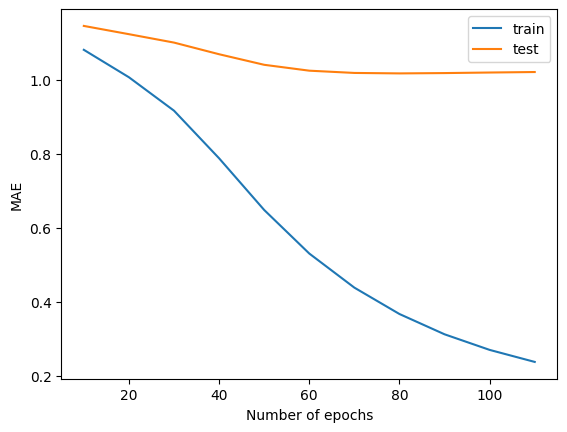

<Figure size 640x480 with 0 Axes>

In [ ]:
#STEP 3

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the hyperparameters for the model
n_factors = 20
n_epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
lr_all = 0.004
reg_all = 0.04

# Train the model for different numbers of epochs and store the resulting MAE scores
train_mae_scores = []
test_mae_scores = []
for num_epochs in n_epochs:
    algo = SVD(n_factors=n_factors, n_epochs=num_epochs, lr_all=lr_all, reg_all=reg_all, random_state=my_seed)
    algo.fit(trainset)
    train_predictions = algo.test(trainset.build_testset())
    test_predictions = algo.test(testset)
    train_mae_scores.append(accuracy.mae(train_predictions))
    test_mae_scores.append(accuracy.mae(test_predictions))

# Plot the MAE scores against the number of epochs
plt.plot(n_epochs, train_mae_scores, label='train')
plt.plot(n_epochs, test_mae_scores, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Export the graph as PNG
plt.savefig('mae_vs_epochs.png')

### SVD++

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVDpp

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [65],
    "n_epochs": [85],
    "lr_all": [0.006],
    "init_mean": [0],
    "init_std_dev": [0.01],
    "reg_all" : [0.06],
    "random_state" :[42],
}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0248971593321812
Best MAE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}
Best RMSE score: 1.2590661026880767
Best RMSE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_init_mean,param_init_std_dev,param_reg_all,param_random_state
0,1.258669,1.263056,1.252278,1.251686,1.272641,1.255007,1.256978,1.274263,1.266543,1.239542,...,0.069209,0.002071,"{'n_factors': 65, 'n_epochs': 85, 'lr_all': 0....",65,85,0.006,0,0.01,0.06,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.4285
MAE: 0.4285127713285531
RMSE: 0.5420
RMSE: 0.5420113854104265


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0109
MAE: 1.0109005724255613
RMSE: 1.2396
RMSE: 1.2395792290753251


### NMF

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = NMF()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [195], # number of latent factors to be learned by the algorithm
    "n_epochs": [50], # number of iterations of the stochastic gradient descent optimization algorithm
    "reg_pu": [0.01], # The regularization term for users. Default is 0.06.
    "reg_qi": [0.3], # The regularization term for items. Default is 0.06.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0697420887007256
Best MAE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}
Best RMSE score: 1.354469749451313
Best RMSE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi,param_random_state
0,1.343185,1.36347,1.357519,1.374781,1.348222,1.329902,1.362592,1.339208,1.364921,1.360897,...,11.170413,0.623987,0.046429,0.015614,"{'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0...",195,50,0.01,0.3,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3330
MAE: 0.3329517102038291
RMSE: 0.4367
RMSE: 0.4367030453613122


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0578
MAE: 1.0578048617143641
RMSE: 1.3425
RMSE: 1.3425367248948514


### KNN

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [15],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1],
       'user_based': [True],
       'shrinkage': [1],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0052790924711252
Best MAE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 1}}
Best RMSE score: 1.2141728751173155
Best RMSE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 1}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.216747,1.19814,1.216741,1.216974,1.229608,1.204613,1.213919,1.227576,1.232169,1.185241,...,1.005279,0.012701,1,2.999498,0.724226,0.539454,0.188405,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.3750
MAE: 0.3749842372832863
RMSE: 0.4848
RMSE: 0.4847557269345437


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  0.9750
MAE: 0.9749880534937041
RMSE: 1.1825
RMSE: 1.1824998544797638


####Recommendation

In [ ]:
# Define a function to get top N recommended vacancies for a given jobseeker
def get_top_n_vacancies(jobseeker_id, n=10):
   
    # Check if the jobseeker ID exists in the dataset
    if jobseeker_id not in df['JobseekerID'].unique():
        print(f"Error: Jobseeker with id {jobseeker_id} does not exist.")
        return
    
    # Get a list of all vacancies
    vacancies = df['VacancyID'].unique().tolist()

    # Create a list of tuples (vacancy_id, predicted_rating) for the given jobseeker
    jobseeker_ratings = [(vacancy_id, round(algo.predict(jobseeker_id, vacancy_id).est, 2)) for vacancy_id in vacancies]
    
    # Filter out the vacancies that the jobseeker has already rated. WHEN THE COMPNAY RECOMMENDS, THIS SHOULD BE INCLUDED
    #rated_vacancies = df.loc[df['JobseekerID'] == jobseeker_id, 'VacancyID'].tolist()
    #jobseeker_ratings = [(vacancy_id, rating) for vacancy_id, rating in jobseeker_ratings if vacancy_id not in rated_vacancies]

    # Sort the list in descending order of predicted rating
    jobseeker_ratings.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top n recommended vacancies for the given jobseeker
    return jobseeker_ratings[:n]

# Prompt the user to input the jobseeker ID
jobseeker_id = int(input("Enter the jobseeker ID: "))

# Get the top N recommended vacancies for the given jobseeker
n = 10  # number of recommended vacancies
jobseeker_ratings = get_top_n_vacancies(jobseeker_id, n)

# Create a DataFrame with two columns, VacancyID and Rating
recommendations = pd.DataFrame(jobseeker_ratings, columns=['VacancyID', 'Rating'])

# Print the top 10 most similar vacancies
print(f"Jobseeker ID {jobseeker_id} matches the following vacancies:")
print(recommendations)


Enter the jobseeker ID: 10466
Jobseeker ID 10466 matches the following vacancies:
   VacancyID  Rating
0      46131    4.41
1      33811    4.28
2      34743    3.55
3      25023    3.52
4      38808    3.35
5      30356    3.33
6      43396    3.33
7      44088    3.33
8      48362    3.33
9      25506    3.33


####Kendall Evaluation

Code iterates over each unique jobseeker ID, gets the actual vacancies that the jobseeker applied for, gets the recommended vacancies for the given jobseeker, finds the common vacancies in actual and recommended vacancies, keeps only the common vacancies in actual and recommended vacancies, and calculates the Kendall rank correlation and Spearman rank correlation if there are at least 2 common vacancies. The average Kendall rank correlation, p-value, Spearman rank correlation, and p-value are printed at the end.

In [ ]:
display(df)

,JobseekerID,VacancyID,Rating
0,20473,30356,4
1,22762,43396,1
2,10466,34808,4
3,10466,36153,2
4,10466,38808,3
...,...,...,...
45312,21446,40802,3
45313,21446,40283,5
45314,21446,42948,2
45315,21446,27350,2


In [ ]:
# Create empty lists to store the correlations and p-values
kendall_corrs = []
kendall_pvalues = []
spearman_corrs = []
spearman_pvalues = []

# Iterate over each unique jobseeker ID
for jobseeker_id in df['JobseekerID'].unique():
    
    # Get the actual vacancies that the jobseeker applied for
    actual_vacancies = df[df['JobseekerID'] == jobseeker_id]['VacancyID'].values
    indices = np.argsort(-df.loc[(df['JobseekerID'] == jobseeker_id) & (df['VacancyID'].isin(actual_vacancies)), 'Rating'])

    # Get the recommended vacancies for the given jobseeker
    jobseeker_recommendations = get_top_n_vacancies(jobseeker_id, n)
    recommended_vacancies = [v[0] for v in jobseeker_recommendations]

    # Find the common vacancies in actual and recommended vacancies
    common_vacancies = np.intersect1d(actual_vacancies, recommended_vacancies, assume_unique=True)
    
     # Only calculate correlations if there are at least 2 common vacancies //explanation on this in doc notes inside model
    if len(common_vacancies) >= 2:

        # Keep only the common vacancies in actual and recommended vacancies
        actual_vacancies = actual_vacancies[np.isin(actual_vacancies, common_vacancies)]
        recommended_vacancies = [v for v in recommended_vacancies if v in common_vacancies]

        # Calculate Kendall rank correlation
        kendall_corr, kendall_pvalue = kendalltau(actual_vacancies, recommended_vacancies)
        kendall_corrs.append(kendall_corr)
        kendall_pvalues.append(kendall_pvalue)

        # Calculate Spearman rank correlation
        spearman_corr, spearman_pvalue = spearmanr(actual_vacancies, recommended_vacancies)
        spearman_corrs.append(spearman_corr)
        spearman_pvalues.append(spearman_pvalue)


# Print the average correlations and p-values
print(f"Average Kendall rank correlation: {np.mean(kendall_corrs)}, p-value: {np.mean(kendall_pvalues)}")
print(f"Average Spearman rank correlation: {np.mean(spearman_corrs)}, p-value: {np.mean(spearman_pvalues)}")

Average Kendall rank correlation: 0.20717290216416598, p-value: 0.697095523073549
Average Spearman rank correlation: 0.2229158630148729, p-value: nan


#### Graph: K against MAE

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [1, 10, 20, 30, 40, 50, 60, 70, 80],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1],
       'user_based': [True],
       'shrinkage': [0],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0085182478920862
Best MAE parameters: {'k': 20, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}
Best RMSE score: 1.213688167629102
Best RMSE parameters: {'k': 20, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.665086,1.647850,1.641957,1.650376,1.660780,1.664863,1.630227,1.640010,1.650882,1.611471,...,1.236519,0.013407,9,2.345732,0.170368,0.272330,0.052362,"{'k': 1, 'sim_options': {'name': 'msd', 'min_s...",1,"{'name': 'msd', 'min_support': 1, 'user_based'..."
1,1.230263,1.212809,1.228092,1.227933,1.239785,1.222188,1.227806,1.242778,1.242713,1.196507,...,1.010837,0.013399,2,2.145577,0.134039,0.341719,0.024540,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
2,1.217395,1.200234,1.213546,1.211783,1.229587,1.206616,1.213465,1.225868,1.232564,1.185823,...,1.008518,0.012112,1,2.260729,0.153490,0.469844,0.091368,"{'k': 20, 'sim_options': {'name': 'msd', 'min_...",20,"{'name': 'msd', 'min_support': 1, 'user_based'..."
3,1.227033,1.211089,1.221203,1.222405,1.240580,1.221572,1.226200,1.238939,1.242224,1.197944,...,1.023348,0.011247,3,2.157889,0.091087,0.475351,0.027220,"{'k': 30, 'sim_options': {'name': 'msd', 'min_...",30,"{'name': 'msd', 'min_support': 1, 'user_based'..."
4,1.242140,1.229133,1.238434,1.238133,1.256040,1.238071,1.243085,1.253901,1.255859,1.216148,...,1.041285,0.010370,4,2.316767,0.185527,0.561984,0.103671,"{'k': 40, 'sim_options': {'name': 'msd', 'min_...",40,"{'name': 'msd', 'min_support': 1, 'user_based'..."
5,1.257189,1.246307,1.254341,1.252031,1.271149,1.253138,1.259085,1.269638,1.269493,1.233423,...,1.057930,0.009835,5,2.253788,0.298064,0.575948,0.040781,"{'k': 50, 'sim_options': {'name': 'msd', 'min_...",50,"{'name': 'msd', 'min_support': 1, 'user_based'..."
6,1.269635,1.260655,1.268365,1.264397,1.283810,1.266892,1.271606,1.281572,1.281033,1.248429,...,1.072386,0.009174,6,2.194322,0.231484,0.582749,0.016345,"{'k': 60, 'sim_options': {'name': 'msd', 'min_...",60,"{'name': 'msd', 'min_support': 1, 'user_based'..."
7,1.281301,1.271722,1.279475,1.275077,1.294505,1.278044,1.284051,1.292459,1.291397,1.259773,...,1.084842,0.008919,7,2.419928,0.324747,0.677639,0.095603,"{'k': 70, 'sim_options': {'name': 'msd', 'min_...",70,"{'name': 'msd', 'min_support': 1, 'user_based'..."
8,1.288321,1.279276,1.286097,1.282306,1.301141,1.285081,1.290950,1.299603,1.298165,1.266719,...,1.092854,0.008660,8,2.427678,0.147995,0.562470,0.111072,"{'k': 80, 'sim_options': {'name': 'msd', 'min_...",80,"{'name': 'msd', 'min_support': 1, 'user_based'..."


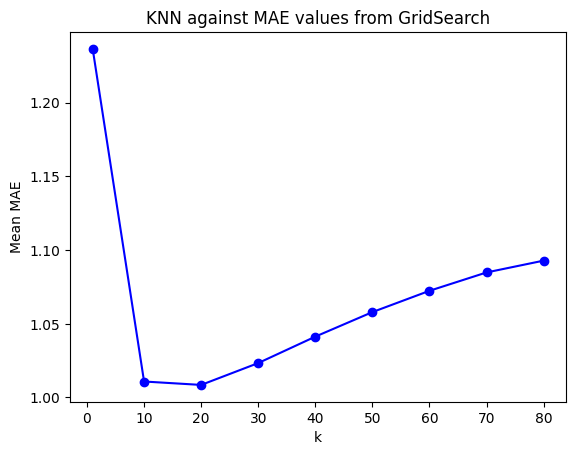

In [ ]:
import matplotlib.pyplot as plt

# Extract k values from results
k_values = [params['k'] for params in results.params]

# Extract mean MAE from results
mean_mae_values = results.mean_test_mae


# Plot results
fig, ax = plt.subplots()

plt.plot(k_values, mean_mae_values, 'bo-')
plt.title('KNN against MAE values from GridSearch')
plt.xlabel('k')
plt.ylabel('Mean MAE')
plt.show()

# Save the figure
fig.savefig('knn_mae_plot.png')

In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.4219
MAE: 0.4218783730375942
RMSE: 0.5375
RMSE: 0.5374568728913074


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  0.9809
MAE: 0.9809216760617719
RMSE: 1.1860
RMSE: 1.1860095382732285


### KNNBaseline

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBaseline

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'user_based': [True] },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': [20],
        'Reg_u': [30],
        'reg_i': [5] },
    }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1,)
gs.fit(data) 

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0051070129692083
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}
Best RMSE score: 1.2153455098298251
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options,param_bsl_options
0,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,1,3.773467,0.132309,0.340219,0.021512,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 25, 'Reg_u': 25,..."
1,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,2,3.956095,0.136797,0.343546,0.025685,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 25, 'Reg_u': 30,..."
2,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,3,4.166448,0.205228,0.343162,0.023361,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 30, 'Reg_u': 25,..."
3,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,4,4.185570,0.258369,0.348820,0.026333,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 30, 'Reg_u': 30,..."
4,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,5,4.134352,0.172379,0.341050,0.023620,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 35, 'Reg_u': 25,..."
5,1.215186,1.209943,1.215494,1.213739,1.224951,1.216521,1.212273,1.231155,1.225986,1.188207,...,0.009294,6,4.157368,0.179192,0.286365,0.073448,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 35, 'Reg_u': 30,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1139
MAE: 0.1139374681005971
RMSE: 0.1508
RMSE: 0.1507643299516966


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  0.9812
MAE: 0.9811939722744315
RMSE: 1.1902
RMSE: 1.1902402409239110


### KNNWithMeans

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNWithMeans

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'min_support': [0],
       'user_based': [True],
       'shrinkage': [95],
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.039237384514855
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}
Best RMSE score: 1.2929135548860138
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.281039,1.285279,1.304004,1.29458,1.305675,1.291357,1.293469,1.302077,1.306011,1.265645,...,1.039237,0.010937,1,6.791407,1.401021,0.671314,0.20504,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 0,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1118
MAE: 0.1118156982236980
RMSE: 0.1532
RMSE: 0.1532482359535018


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0108
MAE: 1.0107704954610053
RMSE: 1.2587
RMSE: 1.2586979869382435


### Co-Clustering

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = CoClustering

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_cltr_u": [3],   # Number of user clusters. Default is 3.
    "n_cltr_i": [15],  # Number of item clusters. Default is 3.
    "n_epochs": [80],  # Number of iteration of the optimization loop. Default is 20.
    "random_state": [42],
}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1195360638139957
Best MAE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}
Best RMSE score: 1.410905411638744
Best RMSE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs,param_random_state
0,1.394734,1.423739,1.404005,1.409255,1.410402,1.401629,1.411079,1.424082,1.440844,1.389284,...,1,7.700799,1.712569,0.027336,0.010612,"{'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80...",3,15,80,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset() #build_full_trainset does NOT split the input data, but changes its data structure only.
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.6983
MAE: 0.6983271044214030
RMSE: 0.9227
RMSE: 0.9227132980073097


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.1059
MAE: 1.1058924620509969
RMSE: 1.3933
RMSE: 1.3932704892193803


## NormalPredictor

In [ ]:
#step 3 equivalent
algo = NormalPredictor()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1)

# Extract mean and std dev for MAE
mae_scores = cv_results['test_mae']
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print results
print("NormalPredictor MAE: average score is {:.4f}, with a standard deviation of {:.4f}".format(mean_mae, std_mae))


NormalPredictor MAE: average score is 1.4723, with a standard deviation of 0.0173


In [ ]:
#algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_war_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  1.4619
MAE: 1.4618775176426118
RMSE: 1.8056
RMSE: 1.8055637977562453


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.4723
MAE: 1.4722859015844176
RMSE: 1.8152
RMSE: 1.8151975594315055


## 10% Noise

### SVD

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set.

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [15, 20, 25], # number of latent factors to be learned by the algorithm
    "n_epochs": [80, 85, 90], # number of iterations of the stochastic gradient descent optimization algorithm
    "lr_all": [0.004], # learning rate for all parameters in the model.
    "reg_all": [0.04], #reduces the risk of overfitting but also reduces the model's expressiveness.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.057912541634772
Best MAE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}
Best RMSE score: 1.2921603683171905
Best RMSE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,1.305527,1.307568,1.284335,1.292667,1.305144,1.284201,1.301423,1.307845,1.315972,1.275538,...,1.147642,0.140760,0.045254,0.010179,"{'n_factors': 15, 'n_epochs': 80, 'lr_all': 0....",15,80,0.004,0.04,42
1,1.306819,1.308880,1.285818,1.294105,1.306109,1.286106,1.303284,1.309559,1.316458,1.277044,...,1.350284,0.218948,0.056854,0.021367,"{'n_factors': 15, 'n_epochs': 85, 'lr_all': 0....",15,85,0.004,0.04,42
2,1.308113,1.310225,1.287513,1.295747,1.307300,1.287942,1.305226,1.311334,1.317081,1.278672,...,1.052338,0.015950,0.049396,0.011596,"{'n_factors': 15, 'n_epochs': 90, 'lr_all': 0....",15,90,0.004,0.04,42
3,1.299012,1.302301,1.286437,1.288470,1.298450,1.289107,1.291785,1.304100,1.295221,1.266722,...,1.028763,0.034358,0.051654,0.013962,"{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0....",20,80,0.004,0.04,42
4,1.300419,1.303799,1.287850,1.289715,1.299758,1.290544,1.293046,1.305279,1.295849,1.267003,...,1.461969,0.193861,0.062215,0.017945,"{'n_factors': 20, 'n_epochs': 85, 'lr_all': 0....",20,85,0.004,0.04,42
5,1.301676,1.305303,1.289230,1.291039,1.301031,1.291855,1.294324,1.306423,1.296593,1.267354,...,1.421298,0.163186,0.054305,0.015165,"{'n_factors': 20, 'n_epochs': 90, 'lr_all': 0....",20,90,0.004,0.04,42
6,1.293985,1.297517,1.289254,1.275753,1.303055,1.287864,1.296729,1.306077,1.308554,1.278330,...,1.324558,0.227856,0.042141,0.005611,"{'n_factors': 25, 'n_epochs': 80, 'lr_all': 0....",25,80,0.004,0.04,42
7,1.295005,1.298262,1.290466,1.276356,1.304195,1.288937,1.298246,1.307040,1.309005,1.279406,...,1.238258,0.149102,0.045300,0.015967,"{'n_factors': 25, 'n_epochs': 85, 'lr_all': 0....",25,85,0.004,0.04,42
8,1.295928,1.298956,1.291569,1.277095,1.305251,1.289933,1.299671,1.307923,1.309452,1.280311,...,1.392224,0.322037,0.038374,0.015949,"{'n_factors': 25, 'n_epochs': 90, 'lr_all': 0....",25,90,0.004,0.04,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3647
MAE: 0.3646934901850662
RMSE: 0.4645
RMSE: 0.4645471268042690


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0396
MAE: 1.0395747369265402
RMSE: 1.2730
RMSE: 1.2729625888601208


### SVD++

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVDpp

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [65],
    "n_epochs": [85],
    "lr_all": [0.006],
    "init_mean": [0],
    "init_std_dev": [0.01],
    "reg_all" : [0.06],
    "random_state" :[42],
}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0477082569860854
Best MAE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}
Best RMSE score: 1.2902975169092905
Best RMSE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_init_mean,param_init_std_dev,param_reg_all,param_random_state
0,1.293939,1.298205,1.283033,1.277323,1.298661,1.28758,1.291982,1.306313,1.296911,1.269027,...,0.069153,0.003539,"{'n_factors': 65, 'n_epochs': 85, 'lr_all': 0....",65,85,0.006,0,0.01,0.06,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.4228
MAE: 0.4228102128132284
RMSE: 0.5376
RMSE: 0.5375837041299564


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0342
MAE: 1.0342044417392835
RMSE: 1.2717
RMSE: 1.2717472712937290


### NMF

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = NMF()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [195], # number of latent factors to be learned by the algorithm
    "n_epochs": [50], # number of iterations of the stochastic gradient descent optimization algorithm
    "reg_pu": [0.01], # The regularization term for users. Default is 0.06.
    "reg_qi": [0.3], # The regularization term for items. Default is 0.06.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0945438319505492
Best MAE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}
Best RMSE score: 1.3920009343235822
Best RMSE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi,param_random_state
0,1.37904,1.384021,1.399137,1.392564,1.414073,1.3789,1.413486,1.398387,1.401349,1.359052,...,10.387644,0.415679,0.034208,0.015693,"{'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0...",195,50,0.01,0.3,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3396
MAE: 0.3396041134067954
RMSE: 0.4493
RMSE: 0.4492854136001719


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0742
MAE: 1.0741761047778886
RMSE: 1.3641
RMSE: 1.3640683459904850


### KNN

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10, 15, 20, 25],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1, 2],
       'user_based': [True],
       'shrinkage': [0, 1, 2],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0309538316840576
Best MAE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}
Best RMSE score: 1.247858223571851
Best RMSE parameters: {'k': 20, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.271522,1.250988,1.260546,1.263191,1.270704,1.250974,1.267857,1.276271,1.276259,1.228442,...,1.035154,0.012218,7,2.454773,0.170941,0.380787,0.090282,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
1,1.271522,1.250988,1.260546,1.263191,1.270704,1.250974,1.267857,1.276271,1.276259,1.228442,...,1.035154,0.012218,8,2.253205,0.069588,0.326332,0.010735,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
2,1.271522,1.250988,1.260546,1.263191,1.270704,1.250974,1.267857,1.276271,1.276259,1.228442,...,1.035154,0.012218,9,2.327083,0.321386,0.382970,0.056893,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
3,1.262418,1.252914,1.254117,1.261006,1.273820,1.246430,1.261677,1.266157,1.266613,1.225182,...,1.038479,0.011262,18,2.233215,0.100527,0.337088,0.037608,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
4,1.262418,1.252914,1.254117,1.261006,1.273820,1.246430,1.261677,1.266157,1.266613,1.225182,...,1.038479,0.011262,17,2.525972,0.327204,0.361214,0.072077,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
5,1.262418,1.252914,1.254117,1.261006,1.273820,1.246430,1.261677,1.266157,1.266613,1.225182,...,1.038479,0.011262,16,2.557459,0.322033,0.399861,0.117862,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
6,1.258764,1.241248,1.245855,1.250920,1.264368,1.239515,1.251217,1.264348,1.260908,1.218629,...,1.030954,0.011509,1,2.347877,0.125100,0.365226,0.020771,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
7,1.258764,1.241248,1.245855,1.250920,1.264368,1.239515,1.251217,1.264348,1.260908,1.218629,...,1.030954,0.011509,2,2.510194,0.346265,0.381363,0.045426,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
8,1.258764,1.241248,1.245855,1.250920,1.264368,1.239515,1.251217,1.264348,1.260908,1.218629,...,1.030954,0.011509,3,2.260574,0.108821,0.357130,0.020317,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
9,1.253025,1.246419,1.242141,1.249892,1.266959,1.240870,1.251438,1.260426,1.256729,1.218762,...,1.036003,0.010647,12,2.408130,0.174850,0.409552,0.080563,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 2, 'user_based'..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.3820
MAE: 0.3820253682004020
RMSE: 0.4968
RMSE: 0.4968320650029535


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0006
MAE: 1.0005993863237486
RMSE: 1.2201
RMSE: 1.2201079109783635


### KNNBaseline

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBaseline

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'user_based': [True] },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': [20],
        'Reg_u': [30],
        'reg_i': [5] },
    }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1,)
gs.fit(data) 

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0280116694691648
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}
Best RMSE score: 1.247257970561066
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options,param_bsl_options
0,1.249533,1.248945,1.241627,1.246851,1.254498,1.245041,1.249125,1.263985,1.252773,1.220202,...,0.008622,1,3.377304,0.384559,0.257945,0.064897,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 20, 'Reg_u': 30,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1125
MAE: 0.1124549459173477
RMSE: 0.1502
RMSE: 0.1502330451002432


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0057
MAE: 1.0057131636297396
RMSE: 1.2261
RMSE: 1.2260887830461846


### KNNWithMeans

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNWithMeans

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'min_support': [0],
       'user_based': [True],
       'shrinkage': [95],
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0632640000857774
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}
Best RMSE score: 1.3242361207872662
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.31515,1.314897,1.33141,1.328055,1.333292,1.327511,1.332731,1.336348,1.327196,1.295771,...,1.063264,0.01059,1,6.695641,1.402375,0.582266,0.117361,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 0,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1104
MAE: 0.1104278015563375
RMSE: 0.1527
RMSE: 0.1526946602802456


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0368
MAE: 1.0368268931785016
RMSE: 1.2927
RMSE: 1.2926614035775634


### Co-Clustering

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = CoClustering

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_cltr_u": [3],   # Number of user clusters. Default is 3.
    "n_cltr_i": [15],  # Number of item clusters. Default is 3.
    "n_epochs": [80],  # Number of iteration of the optimization loop. Default is 20.
    "random_state": [42],
}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1445393341729475
Best MAE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}
Best RMSE score: 1.4462425965621286
Best RMSE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs,param_random_state
0,1.442623,1.449353,1.429537,1.439209,1.446922,1.441052,1.440062,1.481439,1.463489,1.42874,...,1,8.892766,1.860983,0.038887,0.017861,"{'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80...",3,15,80,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset() #build_full_trainset does NOT split the input data, but changes its data structure only.
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.7036
MAE: 0.7035985127123491
RMSE: 0.9372
RMSE: 0.9371509705009159


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.1258
MAE: 1.1257936793779382
RMSE: 1.4237
RMSE: 1.4237127030523984


### NormalPredictor

In [ ]:
#step 3 equivalent
algo = NormalPredictor()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1)

# Extract mean and std dev for MAE
mae_scores = cv_results['test_mae']
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print results
print("NormalPredictor MAE: average score is {:.4f}, with a standard deviation of {:.4f}".format(mean_mae, std_mae))


NormalPredictor MAE: average score is 1.4706, with a standard deviation of 0.0109


In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_war_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  1.4553
MAE: 1.4553307934630042
RMSE: 1.8037
RMSE: 1.8037162751291695


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.4640
MAE: 1.4640021785181132
RMSE: 1.8108
RMSE: 1.8108237851743341


## 20% Noise

### SVD

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set.

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [15, 20, 25], # number of latent factors to be learned by the algorithm
    "n_epochs": [80, 85, 90], # number of iterations of the stochastic gradient descent optimization algorithm
    "lr_all": [0.004], # learning rate for all parameters in the model.
    "reg_all": [0.04], #reduces the risk of overfitting but also reduces the model's expressiveness.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0824091339606585
Best MAE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}
Best RMSE score: 1.328628430620935
Best RMSE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,1.342471,1.343346,1.324127,1.337317,1.350456,1.324078,1.324820,1.348563,1.349340,1.307821,...,0.951866,0.012241,0.045510,0.012965,"{'n_factors': 15, 'n_epochs': 80, 'lr_all': 0....",15,80,0.004,0.04,42
1,1.344583,1.345359,1.325955,1.339612,1.353076,1.326489,1.326629,1.350588,1.350693,1.309959,...,1.087125,0.093442,0.050261,0.020895,"{'n_factors': 15, 'n_epochs': 85, 'lr_all': 0....",15,85,0.004,0.04,42
2,1.346332,1.347082,1.327695,1.341810,1.355630,1.328704,1.328329,1.352644,1.351882,1.311973,...,1.060386,0.009934,0.041906,0.008397,"{'n_factors': 15, 'n_epochs': 90, 'lr_all': 0....",15,90,0.004,0.04,42
3,1.339181,1.337065,1.318276,1.328301,1.339213,1.331309,1.317097,1.347491,1.330684,1.297666,...,1.201690,0.156162,0.056122,0.033205,"{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0....",20,80,0.004,0.04,42
4,1.341259,1.338525,1.319657,1.330489,1.341037,1.332786,1.318460,1.349203,1.331635,1.298622,...,1.279003,0.207110,0.041787,0.005939,"{'n_factors': 20, 'n_epochs': 85, 'lr_all': 0....",20,85,0.004,0.04,42
5,1.342876,1.339711,1.320798,1.332494,1.342623,1.334040,1.319629,1.350726,1.332446,1.299358,...,1.229727,0.111747,0.040888,0.002660,"{'n_factors': 20, 'n_epochs': 90, 'lr_all': 0....",20,90,0.004,0.04,42
6,1.336885,1.330933,1.321385,1.330216,1.340710,1.330185,1.324573,1.352441,1.340882,1.309284,...,1.133327,0.021031,0.049183,0.013995,"{'n_factors': 25, 'n_epochs': 80, 'lr_all': 0....",25,80,0.004,0.04,42
7,1.338386,1.332175,1.322592,1.331365,1.342005,1.331097,1.325800,1.353707,1.341475,1.310324,...,1.412383,0.233233,0.050137,0.021228,"{'n_factors': 25, 'n_epochs': 85, 'lr_all': 0....",25,85,0.004,0.04,42
8,1.339582,1.333141,1.323590,1.332328,1.343028,1.331816,1.326750,1.354658,1.341865,1.311061,...,1.275310,0.216590,0.037142,0.014091,"{'n_factors': 25, 'n_epochs': 90, 'lr_all': 0....",25,90,0.004,0.04,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3560
MAE: 0.3560345064957829
RMSE: 0.4561
RMSE: 0.4560634448750068


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0670
MAE: 1.0670464235455317
RMSE: 1.3165
RMSE: 1.3165216332772043


### SVD++

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVDpp

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [65],
    "n_epochs": [85],
    "lr_all": [0.006],
    "init_mean": [0],
    "init_std_dev": [0.01],
    "reg_all" : [0.06],
    "random_state" :[42],
}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0765878081638818
Best MAE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}
Best RMSE score: 1.3312496686748558
Best RMSE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_init_mean,param_init_std_dev,param_reg_all,param_random_state
0,1.336666,1.335238,1.320419,1.331335,1.342262,1.334927,1.32059,1.350417,1.332736,1.307907,...,0.070388,0.002755,"{'n_factors': 65, 'n_epochs': 85, 'lr_all': 0....",65,85,0.006,0,0.01,0.06,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.4116
MAE: 0.4115546524855764
RMSE: 0.5265
RMSE: 0.5265290556521320


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0620
MAE: 1.0619634069757076
RMSE: 1.3155
RMSE: 1.3154686568419696


### NMF

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = NMF()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [195], # number of latent factors to be learned by the algorithm
    "n_epochs": [50], # number of iterations of the stochastic gradient descent optimization algorithm
    "reg_pu": [0.01], # The regularization term for users. Default is 0.06.
    "reg_qi": [0.3], # The regularization term for items. Default is 0.06.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1142915754368943
Best MAE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}
Best RMSE score: 1.4369260271989368
Best RMSE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi,param_random_state
0,1.431506,1.426046,1.448833,1.444309,1.458242,1.437565,1.431194,1.450351,1.439195,1.402019,...,10.335544,0.408049,0.047974,0.024637,"{'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0...",195,50,0.01,0.3,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3548
MAE: 0.3547654038142690
RMSE: 0.4782
RMSE: 0.4781699325186659


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0923
MAE: 1.0923172516476953
RMSE: 1.4132
RMSE: 1.4131946849902510


### KNN

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10, 15, 20, 25],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1, 2],
       'user_based': [True],
       'shrinkage': [0, 1, 2],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0570967999559853
Best MAE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}
Best RMSE score: 1.2862993739268949
Best RMSE parameters: {'k': 20, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.310363,1.298145,1.298868,1.306906,1.305206,1.303082,1.294124,1.335231,1.311350,1.281619,...,1.063036,0.013048,13,2.365100,0.293265,0.378982,0.095054,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
1,1.310363,1.298145,1.298868,1.306906,1.305206,1.303082,1.294124,1.335231,1.311350,1.281619,...,1.063036,0.013048,15,2.215938,0.084478,0.351208,0.066185,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
2,1.310363,1.298145,1.298868,1.306906,1.305206,1.303082,1.294124,1.335231,1.311350,1.281619,...,1.063036,0.013048,14,2.405786,0.207127,0.372487,0.080343,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
3,1.301620,1.296535,1.295347,1.306452,1.303531,1.302044,1.288151,1.329536,1.305962,1.274376,...,1.065603,0.012224,21,2.560329,0.281302,0.361030,0.050453,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
4,1.301620,1.296535,1.295347,1.306452,1.303531,1.302044,1.288151,1.329536,1.305962,1.274376,...,1.065603,0.012224,20,2.562662,0.272453,0.388685,0.073128,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
5,1.301620,1.296535,1.295347,1.306452,1.303531,1.302044,1.288151,1.329536,1.305962,1.274376,...,1.065603,0.012224,19,2.720052,0.283134,0.379655,0.053429,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
6,1.298142,1.282325,1.280255,1.291495,1.298505,1.287876,1.282880,1.322387,1.296968,1.261600,...,1.057097,0.013586,1,2.515105,0.277707,0.402210,0.061331,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
7,1.298142,1.282325,1.280255,1.291495,1.298505,1.287876,1.282880,1.322387,1.296968,1.261600,...,1.057097,0.013586,2,2.688128,0.329653,0.415077,0.061073,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
8,1.298142,1.282325,1.280255,1.291495,1.298505,1.287876,1.282880,1.322387,1.296968,1.261600,...,1.057097,0.013586,3,2.702888,0.301000,0.437370,0.063224,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
9,1.291871,1.286641,1.281337,1.293834,1.298131,1.290536,1.279277,1.318509,1.295433,1.259497,...,1.061474,0.012276,8,2.224840,0.110308,0.356647,0.023308,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 2, 'user_based'..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.3882
MAE: 0.3881988300534271
RMSE: 0.5120
RMSE: 0.5120078506007369


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0337
MAE: 1.0336986462012752
RMSE: 1.2688
RMSE: 1.2687612596570250


### KNNBaseline

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBaseline

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'user_based': [True] },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': [20],
        'Reg_u': [30],
        'reg_i': [5] },
    }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1,)
gs.fit(data) 

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0560939565275416
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}
Best RMSE score: 1.2895082796289372
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options,param_bsl_options
0,1.295424,1.288893,1.283604,1.293285,1.294511,1.296953,1.272744,1.316103,1.289969,1.263595,...,0.011354,1,3.483785,0.453268,0.225405,0.038191,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 20, 'Reg_u': 30,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1102
MAE: 0.1102031537113445
RMSE: 0.1491
RMSE: 0.1491269617738193


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0343
MAE: 1.0343006774978225
RMSE: 1.2691
RMSE: 1.2690894780798900


### KNNWithMeans

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNWithMeans

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'min_support': [0],
       'user_based': [True],
       'shrinkage': [95],
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0940475847926403
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}
Best RMSE score: 1.3689498662659763
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.358557,1.359813,1.377727,1.375327,1.383414,1.380754,1.345562,1.391318,1.37334,1.343688,...,1.094048,0.013634,1,8.353821,1.314527,0.916813,0.385916,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 0,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1085
MAE: 0.1084729609433143
RMSE: 0.1516
RMSE: 0.1515622747000656


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0660
MAE: 1.0660270036547572
RMSE: 1.3387
RMSE: 1.3387093707867357


### Co-Clustering

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = CoClustering

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_cltr_u": [3],   # Number of user clusters. Default is 3.
    "n_cltr_i": [15],  # Number of item clusters. Default is 3.
    "n_epochs": [80],  # Number of iteration of the optimization loop. Default is 20.
    "random_state": [42],
}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1697319770310552
Best MAE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}
Best RMSE score: 1.481776322614245
Best RMSE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs,param_random_state
0,1.469777,1.483622,1.4755,1.484975,1.493064,1.488544,1.470439,1.502373,1.483816,1.465654,...,1,7.88431,0.930964,0.031841,0.009735,"{'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80...",3,15,80,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset() #build_full_trainset does NOT split the input data, but changes its data structure only.
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.7154
MAE: 0.7153803325050164
RMSE: 0.9598
RMSE: 0.9598211413909458


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.1375
MAE: 1.1374909390333090
RMSE: 1.4477
RMSE: 1.4476905678058833


### NormalPredictor

In [ ]:
#step 3 equivalent
algo = NormalPredictor()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1)

# Extract mean and std dev for MAE
mae_scores = cv_results['test_mae']
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print results
print("NormalPredictor MAE: average score is {:.4f}, with a standard deviation of {:.4f}".format(mean_mae, std_mae))


NormalPredictor MAE: average score is 1.4485, with a standard deviation of 0.0129


In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_war_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  1.4386
MAE: 1.4386145626627334
RMSE: 1.7911
RMSE: 1.7910890289599739


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.4436
MAE: 1.4435834544702240
RMSE: 1.7970
RMSE: 1.7969784627960967


## 30% Noise

### SVD

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set.

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [15, 20, 25], # number of latent factors to be learned by the algorithm
    "n_epochs": [80, 85, 90], # number of iterations of the stochastic gradient descent optimization algorithm
    "lr_all": [0.004], # learning rate for all parameters in the model.
    "reg_all": [0.04], #reduces the risk of overfitting but also reduces the model's expressiveness.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.080599979306308
Best MAE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}
Best RMSE score: 1.3258975369300239
Best RMSE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,1.334261,1.338246,1.329620,1.336206,1.331443,1.323028,1.331167,1.337948,1.325248,1.327862,...,0.969125,0.016121,0.043455,0.010846,"{'n_factors': 15, 'n_epochs': 80, 'lr_all': 0....",15,80,0.004,0.04,42
1,1.336135,1.340747,1.331729,1.337564,1.333777,1.325608,1.333307,1.340418,1.326531,1.330494,...,1.031952,0.015438,0.040531,0.004360,"{'n_factors': 15, 'n_epochs': 85, 'lr_all': 0....",15,85,0.004,0.04,42
2,1.337758,1.342859,1.333663,1.338843,1.336050,1.327953,1.335330,1.342743,1.327731,1.332889,...,1.282627,0.250686,0.047503,0.018204,"{'n_factors': 15, 'n_epochs': 90, 'lr_all': 0....",15,90,0.004,0.04,42
3,1.330037,1.329152,1.328601,1.335614,1.323032,1.323625,1.324047,1.332268,1.315737,1.316863,...,1.160077,0.134208,0.042069,0.004915,"{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0....",20,80,0.004,0.04,42
4,1.331548,1.331166,1.330330,1.337428,1.324747,1.325269,1.325529,1.333466,1.316984,1.317797,...,1.108575,0.010739,0.039025,0.001160,"{'n_factors': 20, 'n_epochs': 85, 'lr_all': 0....",20,85,0.004,0.04,42
5,1.332871,1.332820,1.331847,1.338957,1.326198,1.326677,1.326895,1.334459,1.318044,1.318520,...,1.184464,0.026909,0.039750,0.001605,"{'n_factors': 20, 'n_epochs': 90, 'lr_all': 0....",20,90,0.004,0.04,42
6,1.329982,1.316973,1.330379,1.325024,1.328804,1.327424,1.327611,1.333601,1.321903,1.322010,...,1.256064,0.164742,0.047149,0.016480,"{'n_factors': 25, 'n_epochs': 80, 'lr_all': 0....",25,80,0.004,0.04,42
7,1.330848,1.318022,1.332000,1.325869,1.330010,1.329005,1.328768,1.334960,1.322916,1.323481,...,1.412363,0.193322,0.042076,0.006447,"{'n_factors': 25, 'n_epochs': 85, 'lr_all': 0....",25,85,0.004,0.04,42
8,1.331563,1.318800,1.333313,1.326619,1.330925,1.330389,1.329697,1.336044,1.323687,1.324649,...,1.244807,0.124120,0.040442,0.013760,"{'n_factors': 25, 'n_epochs': 90, 'lr_all': 0....",25,90,0.004,0.04,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3575
MAE: 0.3575254083334508
RMSE: 0.4583
RMSE: 0.4582995442839530


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0667
MAE: 1.0667325245293318
RMSE: 1.3127
RMSE: 1.3126689199927524


### SVD++

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVDpp

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [65],
    "n_epochs": [85],
    "lr_all": [0.006],
    "init_mean": [0],
    "init_std_dev": [0.01],
    "reg_all" : [0.06],
    "random_state" :[42],
}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.07300042876764
Best MAE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}
Best RMSE score: 1.327487010544851
Best RMSE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_init_mean,param_init_std_dev,param_reg_all,param_random_state
0,1.332735,1.329586,1.330545,1.333983,1.3245,1.330702,1.324637,1.334763,1.309662,1.323758,...,0.06932,0.002042,"{'n_factors': 65, 'n_epochs': 85, 'lr_all': 0....",65,85,0.006,0,0.01,0.06,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.4131
MAE: 0.4131468557910959
RMSE: 0.5281
RMSE: 0.5281069780589643


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0611
MAE: 1.0610656351312531
RMSE: 1.3143
RMSE: 1.3143202059606673


### NMF

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = NMF()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [195], # number of latent factors to be learned by the algorithm
    "n_epochs": [50], # number of iterations of the stochastic gradient descent optimization algorithm
    "reg_pu": [0.01], # The regularization term for users. Default is 0.06.
    "reg_qi": [0.3], # The regularization term for items. Default is 0.06.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.11025459865327
Best MAE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}
Best RMSE score: 1.4335090881826156
Best RMSE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi,param_random_state
0,1.431821,1.425871,1.44103,1.442747,1.446177,1.422301,1.444737,1.434124,1.428999,1.417283,...,10.406472,0.416969,0.030119,0.009201,"{'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0...",195,50,0.01,0.3,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3545
MAE: 0.3544908774036263
RMSE: 0.4783
RMSE: 0.4782692812550334


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0926
MAE: 1.0925537208764216
RMSE: 1.4159
RMSE: 1.4158853880892062


### KNN

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10, 15, 20, 25],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1, 2],
       'user_based': [True],
       'shrinkage': [0, 1, 2],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0551722941363813
Best MAE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}
Best RMSE score: 1.2836544392356877
Best RMSE parameters: {'k': 20, 'sim_options': {'name': 'msd', 'min_support': 2, 'user_based': True, 'shrinkage': 0}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.308075,1.293477,1.302883,1.314807,1.300196,1.284061,1.304592,1.316924,1.292132,1.284701,...,1.061287,0.007733,16,2.318452,0.033615,0.355956,0.070484,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
1,1.308075,1.293477,1.302883,1.314807,1.300196,1.284061,1.304592,1.316924,1.292132,1.284701,...,1.061287,0.007733,18,2.450148,0.280586,0.370005,0.053457,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
2,1.308075,1.293477,1.302883,1.314807,1.300196,1.284061,1.304592,1.316924,1.292132,1.284701,...,1.061287,0.007733,17,2.437678,0.147849,0.383262,0.063421,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
3,1.299771,1.296000,1.295108,1.309920,1.294827,1.287249,1.301065,1.308053,1.283320,1.279076,...,1.063086,0.007251,21,2.431591,0.155764,0.332993,0.013415,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
4,1.299771,1.296000,1.295108,1.309920,1.294827,1.287249,1.301065,1.308053,1.283320,1.279076,...,1.063086,0.007251,20,2.627643,0.244757,0.351010,0.038996,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
5,1.299771,1.296000,1.295108,1.309920,1.294827,1.287249,1.301065,1.308053,1.283320,1.279076,...,1.063086,0.007251,19,2.227596,0.053693,0.314990,0.018773,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
6,1.294851,1.283932,1.289309,1.300781,1.284335,1.277422,1.290763,1.298828,1.279055,1.269283,...,1.055172,0.006915,1,2.545251,0.378040,0.391019,0.052715,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
7,1.294851,1.283932,1.289309,1.300781,1.284335,1.277422,1.290763,1.298828,1.279055,1.269283,...,1.055172,0.006915,2,2.373201,0.079295,0.359710,0.017813,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
8,1.294851,1.283932,1.289309,1.300781,1.284335,1.277422,1.290763,1.298828,1.279055,1.269283,...,1.055172,0.006915,3,2.594779,0.354775,0.392420,0.037674,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
9,1.291171,1.286030,1.285508,1.295990,1.282083,1.280551,1.290227,1.292748,1.276747,1.268605,...,1.058409,0.005850,8,2.515903,0.123443,0.373502,0.014606,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 2, 'user_based'..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.3875
MAE: 0.3875394282305878
RMSE: 0.5121
RMSE: 0.5121234423951951


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0294
MAE: 1.0293838345521469
RMSE: 1.2617
RMSE: 1.2617433451302762


### KNNBaseline

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBaseline

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'user_based': [True] },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': [20],
        'Reg_u': [30],
        'reg_i': [5] },
    }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1,)
gs.fit(data) 

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0521554181683719
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}
Best RMSE score: 1.2854350593182773
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options,param_bsl_options
0,1.283563,1.28644,1.290356,1.292145,1.278285,1.281385,1.286909,1.297105,1.282422,1.275741,...,0.004975,1,3.445826,0.457816,0.217491,0.007676,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 20, 'Reg_u': 30,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1096
MAE: 0.1096045540500240
RMSE: 0.1486
RMSE: 0.1486159417844250


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0347
MAE: 1.0347305223307006
RMSE: 1.2680
RMSE: 1.2680331436543282


### KNNWithMeans

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNWithMeans

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'min_support': [0],
       'user_based': [True],
       'shrinkage': [95],
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.088422995726929
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}
Best RMSE score: 1.361507528822481
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.354552,1.354666,1.373652,1.373997,1.361675,1.359715,1.360054,1.368258,1.354961,1.353546,...,1.088423,0.004856,1,7.233845,1.320184,0.786151,0.390948,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 0,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1080
MAE: 0.1079858350595592
RMSE: 0.1511
RMSE: 0.1510770888471702


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0723
MAE: 1.0722653716617994
RMSE: 1.3420
RMSE: 1.3420460587852561


### Co-Clustering

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = CoClustering

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_cltr_u": [3],   # Number of user clusters. Default is 3.
    "n_cltr_i": [15],  # Number of item clusters. Default is 3.
    "n_epochs": [80],  # Number of iteration of the optimization loop. Default is 20.
    "random_state": [42],
}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1631537781634051
Best MAE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}
Best RMSE score: 1.474534620300821
Best RMSE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs,param_random_state
0,1.481188,1.464213,1.469633,1.484797,1.48545,1.460263,1.475868,1.493536,1.462172,1.468225,...,1,8.2856,1.142464,0.042283,0.02847,"{'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80...",3,15,80,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset() #build_full_trainset does NOT split the input data, but changes its data structure only.
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.7198
MAE: 0.7197877223788971
RMSE: 0.9618
RMSE: 0.9618008785835779


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.1515
MAE: 1.1515380232620709
RMSE: 1.4575
RMSE: 1.4575234145420835


### NormalPredictor

In [ ]:
#step 3 equivalent
algo = NormalPredictor()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1)

# Extract mean and std dev for MAE
mae_scores = cv_results['test_mae']
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print results
print("NormalPredictor MAE: average score is {:.4f}, with a standard deviation of {:.4f}".format(mean_mae, std_mae))


NormalPredictor MAE: average score is 1.4397, with a standard deviation of 0.0129


In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_war_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  1.4619
MAE: 1.4618775176426118
RMSE: 1.8056
RMSE: 1.8055637977562453


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.4723
MAE: 1.4722859015844176
RMSE: 1.8152
RMSE: 1.8151975594315055


## 40% Noise

### SVD

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set.

# Define the algortihm to be used for GridSearch
algo = SVD()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [15, 20, 25], # number of latent factors to be learned by the algorithm
    "n_epochs": [80, 85, 90], # number of iterations of the stochastic gradient descent optimization algorithm
    "lr_all": [0.004], # learning rate for all parameters in the model.
    "reg_all": [0.04], #reduces the risk of overfitting but also reduces the model's expressiveness.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0816870914282501
Best MAE parameters: {'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}
Best RMSE score: 1.3289198007870169
Best RMSE parameters: {'n_factors': 25, 'n_epochs': 80, 'lr_all': 0.004, 'reg_all': 0.04, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,1.347855,1.364358,1.329175,1.350801,1.356581,1.318967,1.331918,1.344078,1.335783,1.309852,...,1.176244,0.145859,0.051559,0.015876,"{'n_factors': 15, 'n_epochs': 80, 'lr_all': 0....",15,80,0.004,0.04,42
1,1.350733,1.367663,1.331049,1.353222,1.359325,1.321117,1.334442,1.346340,1.338084,1.312701,...,1.069298,0.015571,0.044784,0.010415,"{'n_factors': 15, 'n_epochs': 85, 'lr_all': 0....",15,85,0.004,0.04,42
2,1.353320,1.370501,1.332800,1.355381,1.361743,1.322966,1.336649,1.348313,1.340185,1.315207,...,1.109288,0.012978,0.043309,0.008479,"{'n_factors': 15, 'n_epochs': 90, 'lr_all': 0....",15,90,0.004,0.04,42
3,1.339875,1.346052,1.319493,1.345785,1.341641,1.321956,1.317358,1.342600,1.324148,1.311544,...,1.068698,0.012218,0.039772,0.001086,"{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0....",20,80,0.004,0.04,42
4,1.341683,1.347324,1.320441,1.347568,1.343531,1.323958,1.318991,1.344592,1.325875,1.312931,...,1.448400,0.203248,0.046536,0.015774,"{'n_factors': 20, 'n_epochs': 85, 'lr_all': 0....",20,85,0.004,0.04,42
5,1.343166,1.348361,1.321330,1.349014,1.345058,1.325560,1.320356,1.346287,1.327323,1.314012,...,1.344672,0.127477,0.044334,0.010363,"{'n_factors': 20, 'n_epochs': 90, 'lr_all': 0....",20,90,0.004,0.04,42
6,1.336608,1.340204,1.332109,1.333506,1.343161,1.310847,1.318158,1.334877,1.327620,1.312108,...,1.165303,0.016679,0.039905,0.001515,"{'n_factors': 25, 'n_epochs': 80, 'lr_all': 0....",25,80,0.004,0.04,42
7,1.337690,1.341565,1.333445,1.335061,1.344586,1.312170,1.319226,1.336442,1.328821,1.313501,...,1.284246,0.069980,0.045366,0.014336,"{'n_factors': 25, 'n_epochs': 85, 'lr_all': 0....",25,85,0.004,0.04,42
8,1.338519,1.342601,1.334482,1.336362,1.345657,1.313265,1.320006,1.337639,1.329790,1.314548,...,1.502961,0.340229,0.038792,0.013815,"{'n_factors': 25, 'n_epochs': 90, 'lr_all': 0....",25,90,0.004,0.04,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3625
MAE: 0.3624542552629140
RMSE: 0.4661
RMSE: 0.4661424493919153


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0695
MAE: 1.0694703438163853
RMSE: 1.3204
RMSE: 1.3203779206046526


### SVD++

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = SVDpp

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [65],
    "n_epochs": [85],
    "lr_all": [0.006],
    "init_mean": [0],
    "init_std_dev": [0.01],
    "reg_all" : [0.06],
    "random_state" :[42],
}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0736239712464506
Best MAE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}
Best RMSE score: 1.3312811961363893
Best RMSE parameters: {'n_factors': 65, 'n_epochs': 85, 'lr_all': 0.006, 'init_mean': 0, 'init_std_dev': 0.01, 'reg_all': 0.06, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_init_mean,param_init_std_dev,param_reg_all,param_random_state
0,1.339023,1.347355,1.322885,1.3386,1.352072,1.320566,1.325308,1.339287,1.321539,1.306177,...,0.070858,0.002435,"{'n_factors': 65, 'n_epochs': 85, 'lr_all': 0....",65,85,0.006,0,0.01,0.06,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.4135
MAE: 0.4135462532230516
RMSE: 0.5303
RMSE: 0.5302735070675275


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0588
MAE: 1.0588264223294537
RMSE: 1.3157
RMSE: 1.3157125336127014


### NMF

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = NMF()

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_factors": [195], # number of latent factors to be learned by the algorithm
    "n_epochs": [50], # number of iterations of the stochastic gradient descent optimization algorithm
    "reg_pu": [0.01], # The regularization term for users. Default is 0.06.
    "reg_qi": [0.3], # The regularization term for items. Default is 0.06.
    "random_state": [42], # make data splits and the random initialization of the SVD algorithm reproducible
}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1025339204838245
Best MAE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}
Best RMSE score: 1.4398359249609285
Best RMSE parameters: {'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0.01, 'reg_qi': 0.3, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi,param_random_state
0,1.435293,1.446164,1.446391,1.452085,1.469377,1.431776,1.44183,1.438973,1.432411,1.404059,...,10.303414,0.324777,0.044049,0.016377,"{'n_factors': 195, 'n_epochs': 50, 'reg_pu': 0...",195,50,0.01,0.3,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.

trainset = data.build_full_trainset() 
#The trainset.build_testset() method creates a test set from the training set.
#build_full_trainset does NOT split the input data, but changes its data structure only. 

algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.3615
MAE: 0.3615494180719169
RMSE: 0.4940
RMSE: 0.4939994706699155


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset) 
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0803
MAE: 1.0802823140363063
RMSE: 1.4115
RMSE: 1.4114913129672715


### KNN

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set

# Define the algortihm to be used for GridSearch
algo = KNNBasic

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10, 15, 20, 25],
    'sim_options': {
       'name': ['msd'],
       'min_support': [1, 2],
       'user_based': [True],
       'shrinkage': [0, 1, 2],
    },
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data)

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0585884227734907
Best MAE parameters: {'k': 15, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}
Best RMSE score: 1.2922765877197997
Best RMSE parameters: {'k': 25, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True, 'shrinkage': 0}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.323646,1.288953,1.309459,1.316567,1.305844,1.306584,1.301812,1.302697,1.332431,1.317881,...,1.064843,0.008906,13,2.311911,0.084648,0.368199,0.100191,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
1,1.323646,1.288953,1.309459,1.316567,1.305844,1.306584,1.301812,1.302697,1.332431,1.317881,...,1.064843,0.008906,15,2.413665,0.237218,0.342525,0.038144,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
2,1.323646,1.288953,1.309459,1.316567,1.305844,1.306584,1.301812,1.302697,1.332431,1.317881,...,1.064843,0.008906,14,2.206302,0.205868,0.359041,0.068848,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 1, 'user_based'..."
3,1.321784,1.292028,1.306207,1.316184,1.299119,1.302648,1.295540,1.305277,1.331304,1.312536,...,1.068691,0.008236,21,2.351277,0.111233,0.357550,0.075462,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
4,1.321784,1.292028,1.306207,1.316184,1.299119,1.302648,1.295540,1.305277,1.331304,1.312536,...,1.068691,0.008236,20,2.243842,0.204199,0.360991,0.051391,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
5,1.321784,1.292028,1.306207,1.316184,1.299119,1.302648,1.295540,1.305277,1.331304,1.312536,...,1.068691,0.008236,19,2.287671,0.213213,0.317322,0.025049,"{'k': 10, 'sim_options': {'name': 'msd', 'min_...",10,"{'name': 'msd', 'min_support': 2, 'user_based'..."
6,1.306323,1.276371,1.297045,1.300666,1.285283,1.293486,1.287954,1.291590,1.322187,1.299647,...,1.058588,0.008523,1,2.443862,0.342983,0.406695,0.065853,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
7,1.306323,1.276371,1.297045,1.300666,1.285283,1.293486,1.287954,1.291590,1.322187,1.299647,...,1.058588,0.008523,2,2.319098,0.115646,0.360591,0.014869,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
8,1.306323,1.276371,1.297045,1.300666,1.285283,1.293486,1.287954,1.291590,1.322187,1.299647,...,1.058588,0.008523,3,2.553595,0.242369,0.408119,0.051833,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 1, 'user_based'..."
9,1.309279,1.279468,1.296446,1.302067,1.283028,1.294083,1.286811,1.293509,1.323035,1.299061,...,1.064220,0.008414,11,2.129678,0.172363,0.354718,0.020875,"{'k': 15, 'sim_options': {'name': 'msd', 'min_...",15,"{'name': 'msd', 'min_support': 2, 'user_based'..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.3880
MAE: 0.3880217316879438
RMSE: 0.5173
RMSE: 0.5173171380251731


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0340
MAE: 1.0339744295284703
RMSE: 1.2673
RMSE: 1.2672600771070504


### KNNBaseline

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNBaseline

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'user_based': [True] },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': [20],
        'Reg_u': [30],
        'reg_i': [5] },
    }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1,)
gs.fit(data) 

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0564399907300552
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}
Best RMSE score: 1.2947857269568597
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 20, 'Reg_u': 30, 'reg_i': 5}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options,param_bsl_options
0,1.312375,1.304612,1.289057,1.30125,1.304356,1.289124,1.289592,1.298402,1.290295,1.268795,...,0.009974,1,3.533301,0.449449,0.215592,0.005154,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'user_based': True}","{'method': 'als', 'n_epochs': 20, 'Reg_u': 30,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1066
MAE: 0.1066425331409796
RMSE: 0.1465
RMSE: 0.1465311656869238


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0322
MAE: 1.0322031627864061
RMSE: 1.2695
RMSE: 1.2694702515564154


### KNNWithMeans

In [ ]:
# STEP 3: Perform grid search over the hyperparameters, fit the algorithm to the training set. 
# After knowing the best parameters you may want to plot k against the MAE. In this case, you may skip the code until then.

# Define the algortihm to be used for GridSearch
algo = KNNWithMeans

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    'k': [10],
    'sim_options': {
       'name': ['pearson_baseline'],
       'min_support': [0],
       'user_based': [True],
       'shrinkage': [95],
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.0885959736758033
Best MAE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}
Best RMSE score: 1.3646760862464105
Best RMSE parameters: {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 0, 'user_based': True, 'shrinkage': 95}}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
0,1.363343,1.375288,1.363856,1.371767,1.391322,1.365181,1.360355,1.368389,1.352527,1.334733,...,1.088596,0.012546,1,4.475387,0.393399,0.418687,0.091359,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 0,..."


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on the train set,
MAE:  0.1052
MAE: 0.1051853669510733
RMSE: 0.1486
RMSE: 0.1486137986324313


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.0655
MAE: 1.0654961823730136
RMSE: 1.3361
RMSE: 1.3360990709524150


### Co-Clustering

In [ ]:
#STEP 3: Perform grid search over the hyperparameters, then fit the tuned algorithm to the training set. Skip this step and proceed to section "Graph" if you want to plot the graph of n_epochs against MAE.

# Define the algortihm to be used for GridSearch
algo = CoClustering

# Define the GridSearchCV object and fit the trainset to it
print("Performing Grid Search...")
param_grid = {
    "n_cltr_u": [3],   # Number of user clusters. Default is 3.
    "n_cltr_i": [15],  # Number of item clusters. Default is 3.
    "n_epochs": [80],  # Number of iteration of the optimization loop. Default is 20.
    "random_state": [42],
}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs = -1)
gs.fit(data) #Recall: this is the train_raw_ratings!

print("Best MAE score:", gs.best_score["mae"])
print("Best MAE parameters:", gs.best_params["mae"])
print("Best RMSE score:", gs.best_score["rmse"])
print("Best RMSE parameters:", gs.best_params["rmse"])

Performing Grid Search...
Best MAE score: 1.1572621163786792
Best MAE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}
Best RMSE score: 1.47440438002891
Best RMSE parameters: {'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80, 'random_state': 42}


In [ ]:
# get the results. This code outputs the tables
results = pd.DataFrame(gs.cv_results)
display(results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs,param_random_state
0,1.475265,1.475391,1.480251,1.478875,1.488105,1.470093,1.475422,1.490949,1.455276,1.454417,...,1,7.215698,1.471115,0.034553,0.016735,"{'n_cltr_u': 3, 'n_cltr_i': 15, 'n_epochs': 80...",3,15,80,42


In [ ]:
algo = gs.best_estimator["mae"]

In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset() #build_full_trainset does NOT split the input data, but changes its data structure only.
algo.fit(trainset)

# Compute biased accuracy on train_raw_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  0.7183
MAE: 0.7182821712554338
RMSE: 0.9650
RMSE: 0.9649776137051909


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.1429
MAE: 1.1428715910334013
RMSE: 1.4567
RMSE: 1.4567317147436691


### NormalPredictor

In [ ]:
#step 3 equivalent
algo = NormalPredictor()
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1)

# Extract mean and std dev for MAE
mae_scores = cv_results['test_mae']
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print results
print("NormalPredictor MAE: average score is {:.4f}, with a standard deviation of {:.4f}".format(mean_mae, std_mae))


NormalPredictor MAE: average score is 1.4139, with a standard deviation of 0.0211


In [ ]:
# Step 4: Fit the algorithm on the training set with the best hyperparameters of MAE, so retrain on the whole set train_raw_ratings.
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train_war_ratings
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the train set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Biased accuracy on the train set,
MAE:  1.4619
MAE: 1.4618775176426118
RMSE: 1.8056
RMSE: 1.8055637977562453


In [ ]:
# Compute unbiased accuracy on test_raw_ratings
testset = data.construct_testset(test_raw_ratings)  # testset is now the set test_raw_rating
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,")
print(f"MAE: {accuracy.mae(predictions):.16f}") 
print(f"RMSE: {accuracy.rmse(predictions):.16f}")

Unbiased accuracy on the test set,
MAE:  1.4723
MAE: 1.4722859015844176
RMSE: 1.8152
RMSE: 1.8151975594315055
